## Importing libraries

In [72]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, GCNConv, SAGEConv # Graph Neural Network 
from torch_geometric.nn import global_mean_pool 
import rpy2.robjects as robjects # load R object 
from rpy2.robjects import pandas2ri # load R object 
from tqdm import tqdm # print progress bar 
import pickle # save object 
import matplotlib.pyplot as plt
import numpy as np
import random as rd 

Load trees and corresponding target parameters and convert them to pandas data.frame

In [27]:
pandas2ri.activate()

fname_graph = "trees-dataset/ntrees-10000-ntaxa-100-1000-lambda-0.1-1-q-0.01-0.1-sscheck-TRUE-df.rds"
fname_param = "trees-dataset/ntrees-10000-ntaxa-100-1000-lambda-0.1-1-q-0.01-0.1-sscheck-TRUE-param.rds"

readRDS = robjects.r['readRDS']
df_graph = readRDS(fname_graph)
df_graph = pandas2ri.rpy2py(df_graph)
df_param = readRDS(fname_param)
df_param = pandas2ri.rpy2py(df_param)

Load Maximum Likelihood predictions

In [28]:
pandas2ri.activate()

fname_mle = "trees-dataset/ntrees-10000-ntaxa-100-1000-lambda-0.1-1-q-0.01-0.1-sscheck-TRUE-mle.rds"

df_mle = readRDS(fname_mle)
df_mle = pandas2ri.rpy2py(df_mle) # contains mle predictions

Checking the total number of trees of the dataset (n_trees) and the number of target parameters for each tree (n_param)

In [29]:
n_param = len(df_param)
n_trees = len(df_graph)
n_trees, n_param

(10000, 6)

In [4]:
def convert_df_to_tensor(df_node, df_edge, params):

    """
    Convert the data frames containing node and edge information 
    to a torch tensor that can be used to feed neural 
    """

    n_node, n_edge = df_node.shape[0], df_edge.shape[0]

    l1, l2 = [], []
    
    for i in range(n_edge):
        edge = df_edge.iloc[i]
        u, v = edge[0]-1, edge[1]-1
        l1 = l1 + [u,v]
        l2 = l2 + [v,u]

    edge_index = torch.tensor([l1,l2], dtype=torch.long)

    x = []

    for i in range(n_node):
        node_attr = list(df_node.iloc[i])
        x.append(node_attr)

    x = torch.tensor(x, dtype = torch.float)

    y = torch.tensor(params, dtype = torch.float)

    data = Data(x = x, edge_index = edge_index, y = y)

    return(data)

In [33]:
batch_size_max = 64
data_list  = []

for n in tqdm(range(n_trees)):
    df_node, df_edge = df_graph[n][0], df_graph[n][1]
    params = [df_param[i][n] for i in range(n_param)]
    data = convert_df_to_tensor(df_node, df_edge, params)
    data_list.append(data)

#dataloader = DataLoader(data_list, batch_size=batch_size_max)

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_10518/1526121493.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  edge_index = torch.tensor([l1,l2], dtype=torch.long)
100%|██████████| 10000/10000 [21:10<00:00,  7.87it/s]


In [32]:
df_node

,dist,mean.edge,time.asym,clade.asym,ancestor,descendant,state
1,28.224345,14.506584,0.000000,0.0,10.0,1,1.0
2,28.224345,13.318217,0.000000,0.0,7.0,1,1.0
3,28.224345,12.921347,0.000000,0.0,10.0,1,0.0
4,28.224345,12.921347,0.000000,0.0,10.0,1,0.0
5,28.224345,12.835079,0.000000,0.0,6.0,1,1.0
...,...,...,...,...,...,...,...
1961,28.002518,0.212979,0.124624,0.0,14.0,2,-1.0
1962,28.070952,0.163499,0.185436,0.0,17.0,2,-1.0
1963,28.210063,0.116921,2.633548,0.0,13.0,2,-1.0
1964,28.183538,0.060266,0.968642,0.0,16.0,2,-1.0


Save or load dataset

In [34]:
save = True

fname = fname_graph[:-6] + "geomtensor" + ".obj" # file name 
if (save):
    print("Save")
    file = open(fname, "wb") # file handler 
    pickle.dump(data_list, file) # save data_list

else:
    print("Load")
    file = open(fname, "rb")
    data_list = pickle.load(file) 

Save


In [48]:
for i in range(len(data_list)):
    data_list[i].y = data_list[i].y[[0,4]]

Split dataset into train, valid and test set.

In [53]:
device = "cuda:2" # GPU to use 
batch_size_max = 16

n_train = 9000
n_test  = 500
n_valid = 500

ind = np.arange(0, n_trees) # all indices from 0 to n_trees
rd.shuffle(ind) # shuffle the indices 
train_ind = ind[0:n_train]
valid_ind = ind[n_train:n_train + n_valid]
test_ind  = ind[n_train + n_valid:]
print(len(train_ind), len(test_ind), len(valid_ind))

train_data = [data_list[i].to(device=device) for i in train_ind]
valid_data = [data_list[i].to(device=device) for i in valid_ind]
test_data  = [data_list[i].to(device=device) for i in test_ind]

train_dl = DataLoader(train_data, batch_size = batch_size_max, shuffle = True)
valid_dl = DataLoader(valid_data, batch_size = batch_size_max, shuffle = True)
test_dl  = DataLoader(test_data , batch_size = 1)

9000 500 500


Create the GNN structure

In [73]:
class GCN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.conv1 = GCNConv(n_in, n_hidden)
        self.conv2 = GCNConv(n_hidden, n_hidden)
        self.conv3 = GCNConv(n_hidden, n_hidden)
        self.conv4 = GCNConv(n_hidden, n_hidden)
        self.conv5 = GCNConv(n_hidden, n_hidden)
        self.conv6 = GCNConv(n_hidden, n_hidden)
        self.conv7 = GCNConv(n_hidden, n_hidden)
        self.conv8 = GCNConv(n_hidden, n_hidden)
        self.conv9 = GCNConv(n_hidden, n_hidden)
        self.conv10 = GCNConv(n_hidden, 2*n_hidden)
        self.lin1  = torch.nn.Linear(2*n_hidden, n_hidden)
        self.lin2  = torch.nn.Linear(n_hidden, n_out)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = self.conv6(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = self.conv7(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = self.conv8(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = self.conv9(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = self.conv10(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.001, training=self.training)
        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        x = self.lin2(x)
        return x

In [65]:
def train(model, batch):
    optimizer.zero_grad()
    out = model(batch)
    batch_size = int(max(data.batch) + 1) # number of trees in the batch 
    loss = F.mse_loss(out, data.y.reshape([batch_size, n_out])) # compute loss 
    loss.backward() # backward propagation 
    optimizer.step()
    return(loss)

def valid(model, batch):
    out = model(batch)
    batch_size = int(max(data.batch) + 1) # number of trees in the batch 
    loss = F.mse_loss(out, data.y.reshape([batch_size, n_out])) # compute loss
    return(loss)

In [74]:
# Setting up the training 
n_in = data_list[0].num_node_features
n_out = len(data_list[0].y)
n_hidden = 50
n_epochs = 10
model = GCN(n_in, n_hidden, n_out).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop 
for epoch in range(n_epochs):

    # Training 
    model.train()
    train_loss = []
    for data in tqdm(train_dl):
        loss = train(model, data) # train model and get loss
        loss = float(loss.to(device = "cpu"))
        train_loss.append(loss)
    mean_loss = np.mean(train_loss)
    print("Epoch %d - Train Loss %.4f" % (epoch, float(mean_loss))) # print progression 

    # Validation 
    model.eval()
    valid_loss = []
    for data in tqdm(valid_dl):
        loss = valid(model, data) # train model and get loss
        loss = float(loss.to(device = "cpu"))
        valid_loss.append(loss)
    mean_loss = np.mean(valid_loss)
    print("Epoch %d - Valid Loss %.4f" % (epoch, float(mean_loss))) # print progression 

100%|██████████| 563/563 [02:50<00:00,  3.31it/s]


Epoch 0 - Train Loss 0.0095


100%|██████████| 32/32 [00:09<00:00,  3.53it/s]


Epoch 0 - Valid Loss 0.0097


100%|██████████| 563/563 [02:50<00:00,  3.31it/s]


Epoch 1 - Train Loss 0.0056


100%|██████████| 32/32 [00:09<00:00,  3.54it/s]


Epoch 1 - Valid Loss 0.0089


100%|██████████| 563/563 [02:50<00:00,  3.30it/s]


Epoch 2 - Train Loss 0.0053


100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


Epoch 2 - Valid Loss 0.0056


100%|██████████| 563/563 [02:50<00:00,  3.30it/s]


Epoch 3 - Train Loss 0.0051


100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Epoch 3 - Valid Loss 0.0072


100%|██████████| 563/563 [02:50<00:00,  3.31it/s]


Epoch 4 - Train Loss 0.0051


100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


Epoch 4 - Valid Loss 0.0063


100%|██████████| 563/563 [02:49<00:00,  3.31it/s]


Epoch 5 - Train Loss 0.0047


100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


Epoch 5 - Valid Loss 0.0046


100%|██████████| 563/563 [02:49<00:00,  3.32it/s]


Epoch 6 - Train Loss 0.0046


100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Epoch 6 - Valid Loss 0.0046


100%|██████████| 563/563 [02:49<00:00,  3.33it/s]


Epoch 7 - Train Loss 0.0045


100%|██████████| 32/32 [00:09<00:00,  3.53it/s]


Epoch 7 - Valid Loss 0.0046


100%|██████████| 563/563 [02:50<00:00,  3.30it/s]


Epoch 8 - Train Loss 0.0043


100%|██████████| 32/32 [00:09<00:00,  3.53it/s]


Epoch 8 - Valid Loss 0.0048


100%|██████████| 563/563 [02:50<00:00,  3.31it/s]


Epoch 9 - Train Loss 0.0039


100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

Epoch 9 - Valid Loss 0.0036


In [58]:
#test_dl = DataLoader(data_list[:500], batch_size = 1)
pred_list, true_list = [[] for n in range(n_param)], [[] for n in range(n_param)]
model.eval()
for data in test_dl:
    out = model(data.to(device=device))
    pred_params = out.tolist()[0]
    true_params = data.y.tolist()
    for n in range(2):
        pred_list[n].append(pred_params[n])
        true_list[n].append(true_params[n])

In [60]:
pred_mle_list = []
for n in [0,4]:
    pred_mle_list.append(df_mle[n][test_ind])

In [91]:
title[1] = "GNN " + title[1]
title

array(['GNN GNN', 'GNN q01'], dtype='<U7')

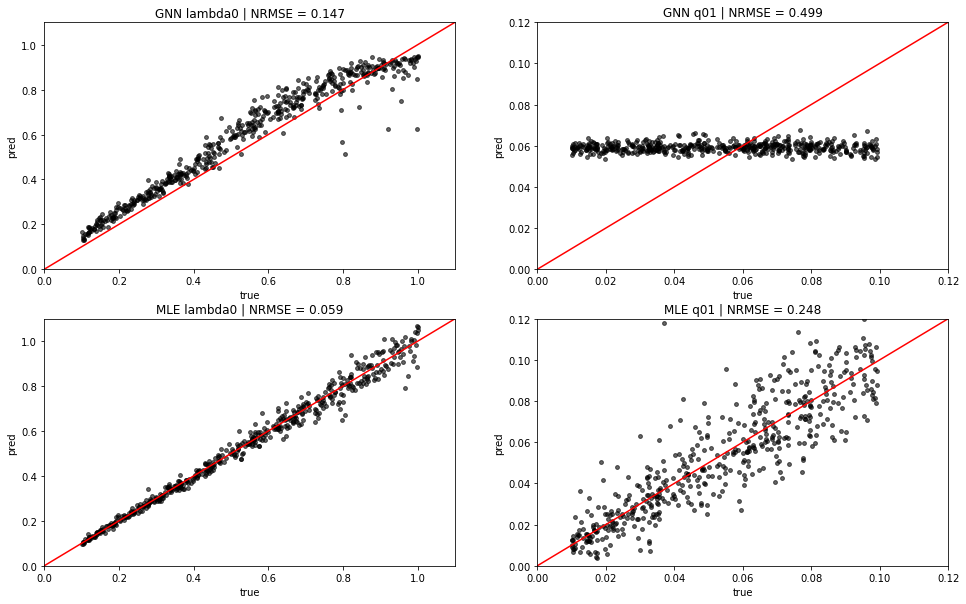

In [94]:
fig, ax = plt.subplots(2,2, figsize = (5*1.62*2,2*5))
lim = [[0.,1.1],[0.,0.12]]
title = np.array(df_mle.names)[[0,4]]
preds = [pred_list, pred_mle_list]
Model = ["GNN ", "MLE "]

for m in range(2):
    for n in range(2):
        ax[m,n].scatter(true_list[n], preds[m][n], s = 15,
                        c = "black", alpha = .6)
        ax[m,n].plot(np.linspace(lim[n][0], lim[n][1]), np.linspace(lim[n][0], lim[n][1]),
                     c = "red")
        ax[m,n].set_xlim(lim[n])
        ax[m,n].set_ylim(lim[n])
        ax[m,n].set_ylabel("pred")
        ax[m,n].set_xlabel("true")
        nrmse = get_nrmse(true_list[n], preds[m][n])
        txt_nrmse = "NRMSE = {nrmse:.3f}"
        ax[m,n].set_title(Model[m] + title[n] + " | " +  txt_nrmse.format(nrmse = nrmse))

In [41]:
def get_nrmse(true, pred):

    """ Compute the Normalized Root Mean Square Error of 
    Predictions vs. Truth """


    mse = np.square(np.subtract(true, pred)).mean()
    rmse = np.sqrt(mse)
    nrmse = rmse / np.mean(true)
    return nrmse

In [54]:
x = torch.rand((18,4), dtype=torch.float)
l = [i for i in range(3700)]
edge_index = torch.tensor([l,l], dtype=torch.long)
y = torch.tensor([1,2,4,5,6,7], dtype=torch.float)

data = Data(x = x, edge_index = edge_index, y = y)
print(data)

model = GCN()
model(data)

Data(x=[18, 4], edge_index=[2, 3700], y=[6])
torch.Size([18, 4]) torch.Size([2, 3700])


IndexError: index 1850 is out of bounds for dimension 0 with size 18

In [119]:
flatten = torch.nn.Flatten(start_dim=-2)
flatten(out)

tensor([ 0.8202, -1.3130,  0.9172, -1.0637,  0.6312, -0.1265], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)